In [1]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# グラフのスタイル設定
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
# データの読み込み
train_df = pd.read_csv('../data/raw/train_df.csv')
test_df = pd.read_csv('../data/raw/test_df.csv')

# 基本情報の表示
print("訓練データの形状:", train_df.shape)
print("\nテストデータの形状:", test_df.shape)

訓練データの形状: (2093080, 18)

テストデータの形状: (243495, 17)


In [3]:
# データ型の確認
print("訓練データの型情報:")
print(train_df.dtypes)
print("\nテストデータの型情報:")
print(test_df.dtypes)

# 欠損値の確認
print("\n訓練データの欠損値:")
print(train_df.isnull().sum())
print("\n欠損値の割合(%):")
print((train_df.isnull().sum() / len(train_df) * 100).round(2))

訓練データの型情報:
測定局コード            int64
日付               object
時                 int64
SO2(ppm)        float64
NO(ppm)         float64
NO2(ppm)        float64
NOx(ppm)        float64
CO(ppm)         float64
Ox(ppm)         float64
NMHC(ppmC)      float64
CH4(ppmC)       float64
THC(ppmC)       float64
SPM(mg/m3)      float64
PM2.5(μg/m3)    float64
WD(16Dir)        object
WS(m/s)         float64
TEMP(℃)         float64
HUM(％)          float64
dtype: object

テストデータの型情報:
測定局コード          int64
日付             object
時               int64
SO2(ppm)      float64
NO(ppm)       float64
NO2(ppm)      float64
NOx(ppm)      float64
CO(ppm)       float64
Ox(ppm)       float64
NMHC(ppmC)    float64
CH4(ppmC)     float64
THC(ppmC)     float64
SPM(mg/m3)    float64
WD(16Dir)      object
WS(m/s)       float64
TEMP(℃)       float64
HUM(％)        float64
dtype: object

訓練データの欠損値:
測定局コード                0
日付                    0
時                     0
SO2(ppm)         857395
NO(ppm)          423795
NO2(ppm)  

In [4]:
# 時刻の修正と日付時刻の結合
def fix_datetime(df):
    # データフレームのコピーを作成
    df = df.copy()
    
    # 24時を0時に変換
    mask_24 = df['時'] == 24
    df.loc[mask_24, '時'] = 0
    
    # 日付をdatetime型に変換
    df['日付'] = pd.to_datetime(df['日付'])
    
    # 24時のデータの日付を1日進める
    df.loc[mask_24, '日付'] = df.loc[mask_24, '日付'] + pd.Timedelta(days=1)
    
    # 日付を指定のフォーマットの文字列に変換
    df['日付'] = df['日付'].dt.strftime('%Y/%m/%d')
    
    # タイムスタンプの作成
    df['timestamp'] = pd.to_datetime(
        df['日付'].astype(str) + ' ' + 
        df['時'].astype(str).str.zfill(2) + ':00:00'
    )
    
    return df

# データの確認
print("変換前の時刻の分布:")
print(train_df['時'].value_counts().sort_index())

# 訓練データとテストデータの修正
train_df = fix_datetime(train_df)
test_df = fix_datetime(test_df)

# 変換結果の確認
print("\n変換後の時刻の分布:")
print(train_df['時'].value_counts().sort_index())

# 時系列の範囲確認
print("\n訓練データの期間:")
print(f"開始: {train_df['timestamp'].min()}")
print(f"終了: {train_df['timestamp'].max()}")
print(f"期間: {train_df['timestamp'].max() - train_df['timestamp'].min()}")

print("\nテストデータの期間:")
print(f"開始: {test_df['timestamp'].min()}")
print(f"終了: {test_df['timestamp'].max()}")
print(f"期間: {test_df['timestamp'].max() - test_df['timestamp'].min()}")

# タイムスタンプの重複チェック
print("\nタイムスタンプの重複チェック:")
print(f"訓練データ: {train_df['timestamp'].duplicated().sum()}件の重複")
print(f"テストデータ: {test_df['timestamp'].duplicated().sum()}件の重複")

# 時間帯ごとのデータ数を確認
print("\n時間帯ごとのデータ数:")
print(train_df.groupby('時')['timestamp'].count().sort_index())

変換前の時刻の分布:
時
1     87221
2     87212
3     87199
4     87185
5     87191
6     87189
7     87186
8     87193
9     87193
10    87185
11    87223
12    87243
13    87252
14    87251
15    87252
16    87228
17    87261
18    87224
19    87239
20    87228
21    87231
22    87233
23    87131
24    87130
Name: count, dtype: int64

変換後の時刻の分布:
時
0     87130
1     87221
2     87212
3     87199
4     87185
5     87191
6     87189
7     87186
8     87193
9     87193
10    87185
11    87223
12    87243
13    87252
14    87251
15    87252
16    87228
17    87261
18    87224
19    87239
20    87228
21    87231
22    87233
23    87131
Name: count, dtype: int64

訓練データの期間:
開始: 2024-04-01 01:00:00
終了: 2025-04-10 22:00:00
期間: 374 days 21:00:00

テストデータの期間:
開始: 2025-02-01 01:00:00
終了: 2025-04-10 22:00:00
期間: 68 days 21:00:00

タイムスタンプの重複チェック:
訓練データ: 2084082件の重複
テストデータ: 241841件の重複

時間帯ごとのデータ数:
時
0     87130
1     87221
2     87212
3     87199
4     87185
5     87191
6     87189
7     87186
8     87193
9    

測定局ごとのデータ数:
測定局コード
22327010    8998
12225090    8998
6422010     8998
7202070     8998
7204110     8998
            ... 
47206020    5167
47207020    5167
47209080    5167
47211050    5167
11408010    3888
Name: count, Length: 264, dtype: int64


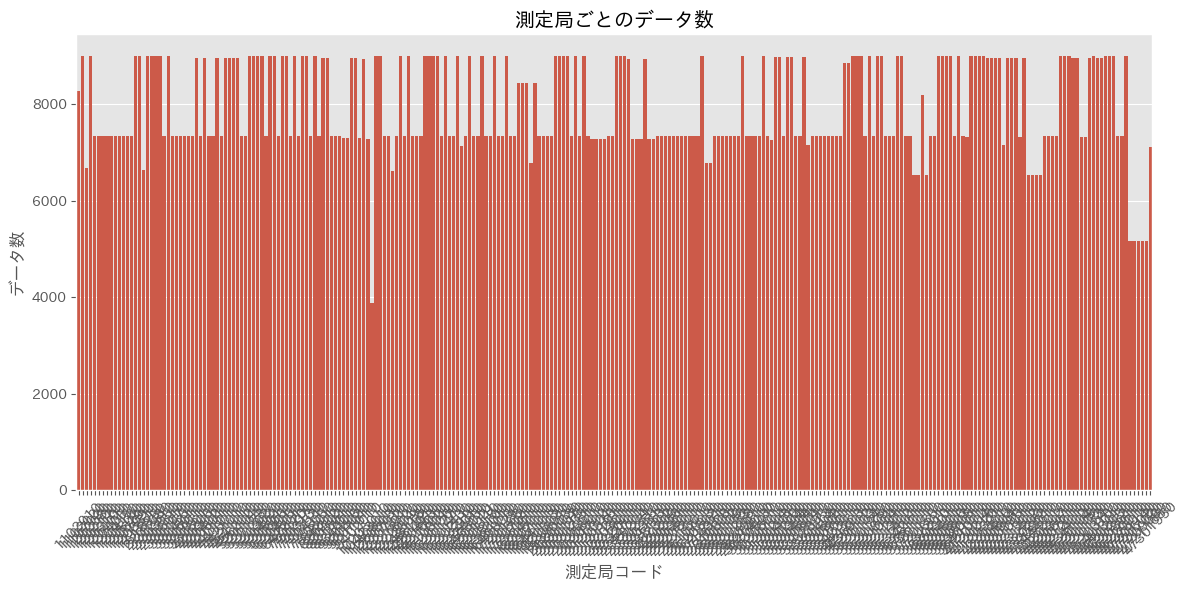

In [5]:
# 測定局ごとのデータ数
station_counts = train_df['測定局コード'].value_counts()
print("測定局ごとのデータ数:")
print(station_counts)

# 測定局ごとのデータ数の可視化
plt.figure(figsize=(12, 6))
sns.barplot(x=station_counts.index, y=station_counts.values)
plt.title('測定局ごとのデータ数')
plt.xlabel('測定局コード')
plt.ylabel('データ数')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

PM2.5の基本統計量:
count    2.056995e+06
mean     7.717652e+00
std      1.562633e+01
min     -1.330000e+03
25%      4.000000e+00
50%      7.000000e+00
75%      1.100000e+01
max      4.500000e+03
Name: PM2.5(μg/m3), dtype: float64


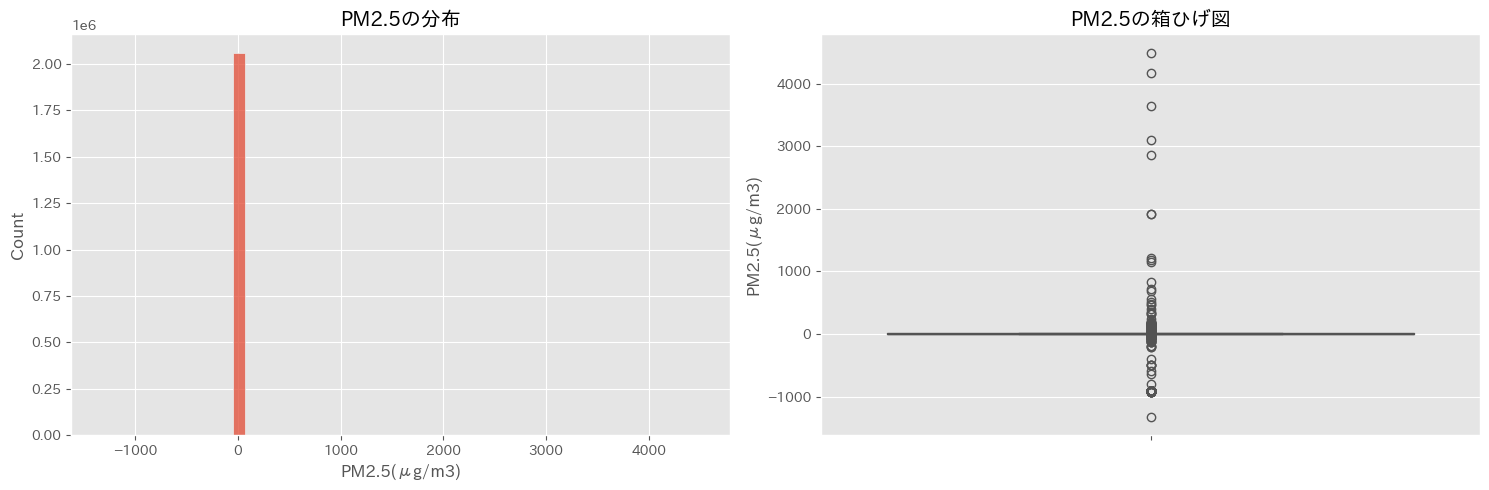

In [6]:
# PM2.5の基本統計量
print("PM2.5の基本統計量:")
print(train_df['PM2.5(μg/m3)'].describe())

# PM2.5の分布可視化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ヒストグラム
sns.histplot(data=train_df, x='PM2.5(μg/m3)', bins=50, ax=ax1)
ax1.set_title('PM2.5の分布')
ax1.set_xlabel('PM2.5(μg/m3)')

# 箱ひげ図
sns.boxplot(data=train_df, y='PM2.5(μg/m3)', ax=ax2)
ax2.set_title('PM2.5の箱ひげ図')

plt.tight_layout()
plt.show()

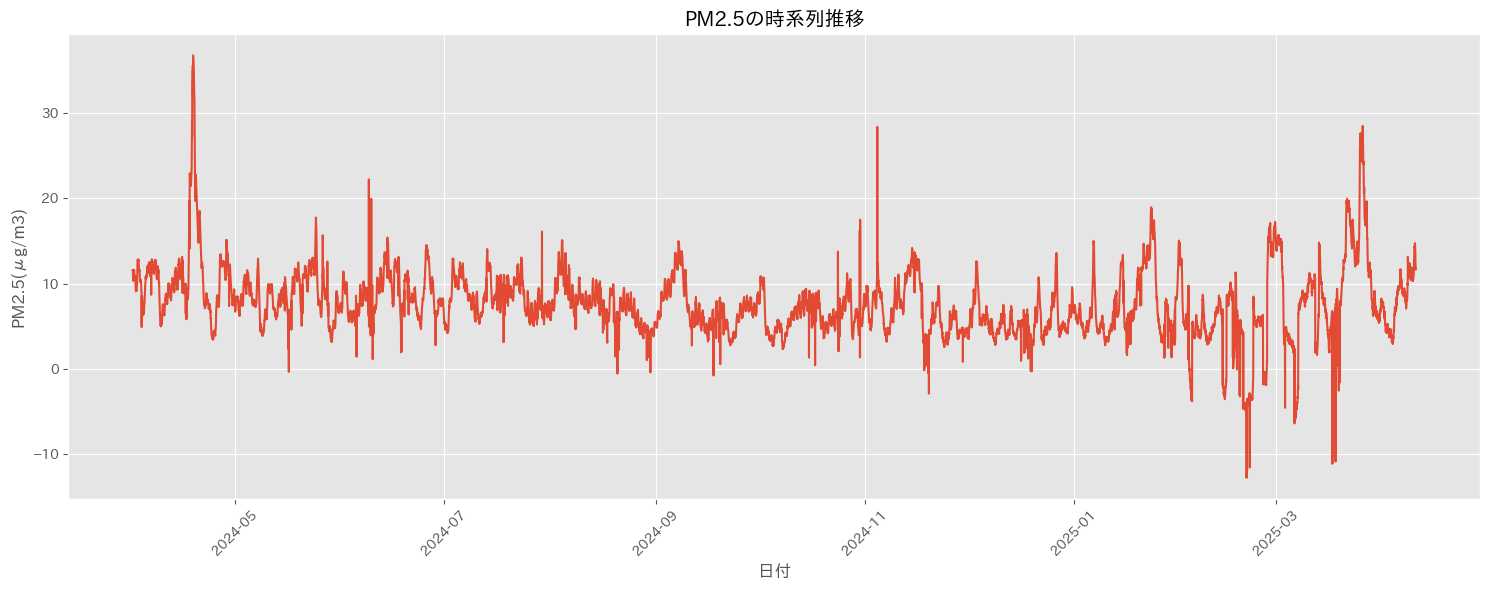

In [7]:
# 日次平均の計算
daily_avg = train_df.groupby('timestamp').agg({
    'PM2.5(μg/m3)': 'mean',
}).reset_index()

# 時系列プロット
plt.figure(figsize=(15, 6))
plt.plot(daily_avg['timestamp'], daily_avg['PM2.5(μg/m3)'])
plt.title('PM2.5の時系列推移')
plt.xlabel('日付')
plt.ylabel('PM2.5(μg/m3)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

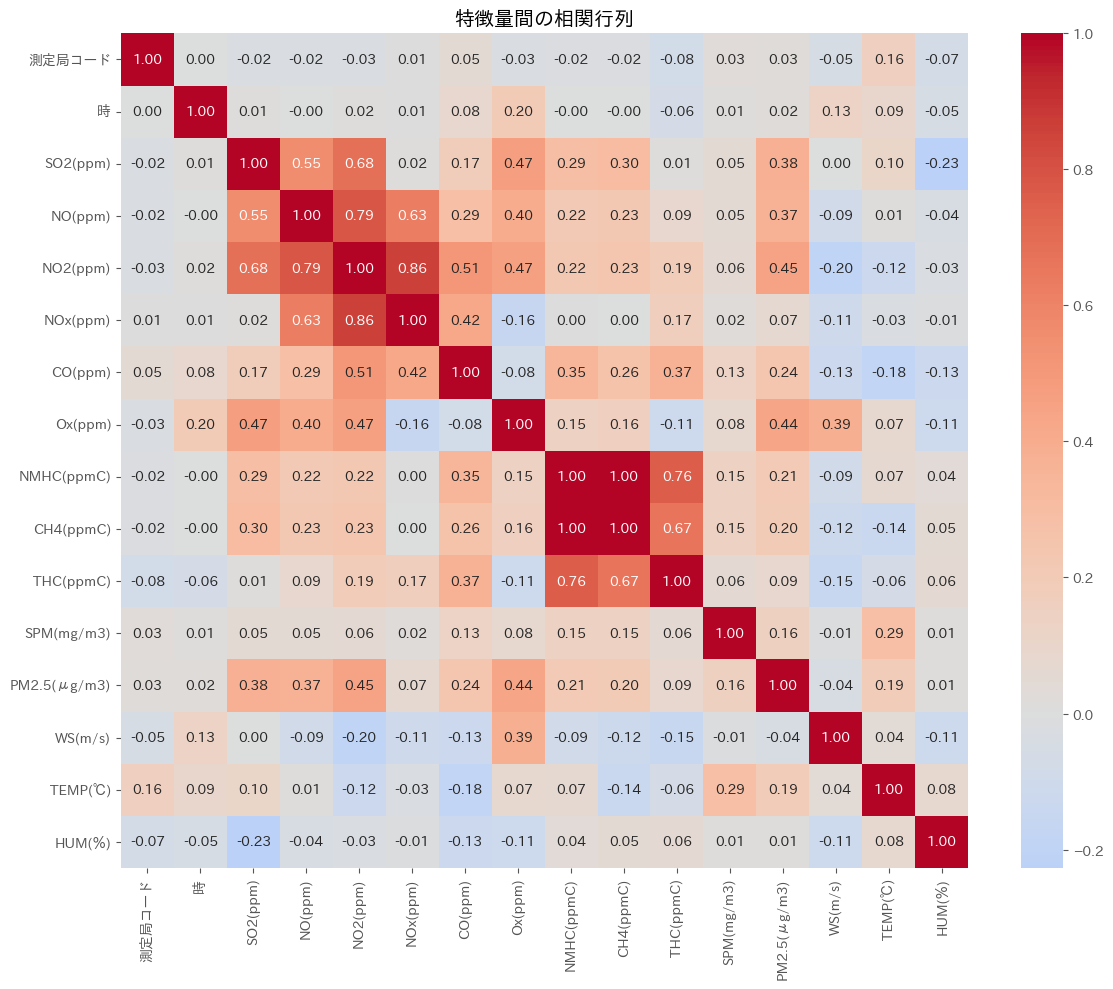


PM2.5との相関係数:
PM2.5(μg/m3)    1.000000
NO2(ppm)        0.445830
Ox(ppm)         0.441951
SO2(ppm)        0.380423
NO(ppm)         0.367919
CO(ppm)         0.237328
NMHC(ppmC)      0.207535
CH4(ppmC)       0.203934
TEMP(℃)         0.190757
SPM(mg/m3)      0.155187
THC(ppmC)       0.087023
NOx(ppm)        0.068410
測定局コード          0.025918
時               0.020933
HUM(％)          0.011256
WS(m/s)        -0.039635
Name: PM2.5(μg/m3), dtype: float64


In [8]:
# 数値型の列のみを選択
numeric_cols = train_df.select_dtypes(include=[np.number]).columns

# 相関行列の計算
corr_matrix = train_df[numeric_cols].corr()

# ヒートマップの作成
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('特徴量間の相関行列')
plt.tight_layout()
plt.show()

# PM2.5との相関
pm25_corr = corr_matrix['PM2.5(μg/m3)'].sort_values(ascending=False)
print("\nPM2.5との相関係数:")
print(pm25_corr)

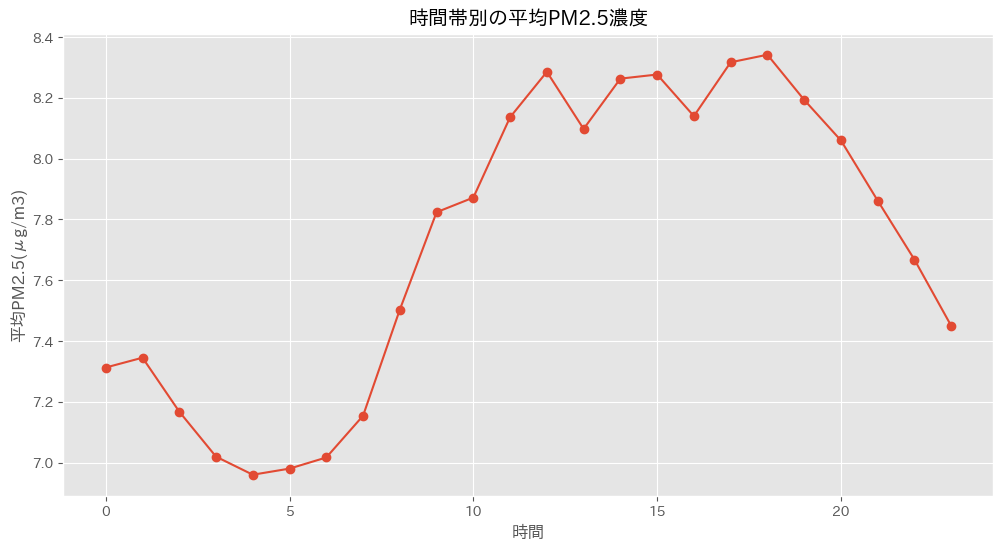

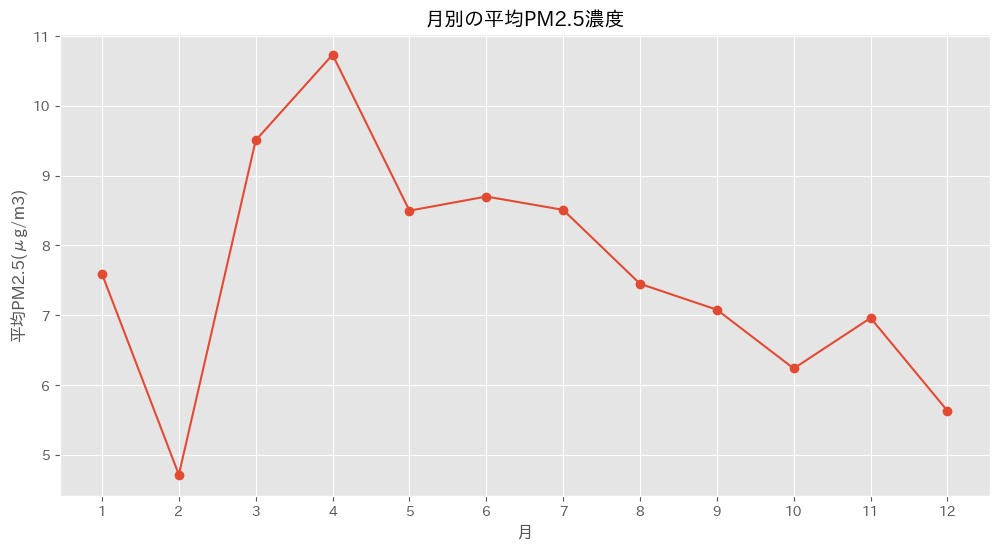

In [9]:
# 時間帯別の平均PM2.5
hourly_avg = train_df.groupby('時')['PM2.5(μg/m3)'].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.title('時間帯別の平均PM2.5濃度')
plt.xlabel('時間')
plt.ylabel('平均PM2.5(μg/m3)')
plt.grid(True)
plt.show()

# 月別の平均PM2.5
train_df['月'] = pd.to_datetime(train_df['日付']).dt.month
test_df['月'] = pd.to_datetime(test_df['日付']).dt.month
monthly_avg = train_df.groupby('月')['PM2.5(μg/m3)'].mean()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title('月別の平均PM2.5濃度')
plt.xlabel('月')
plt.ylabel('平均PM2.5(μg/m3)')
plt.grid(True)
plt.xticks(range(1, 13))
plt.show()

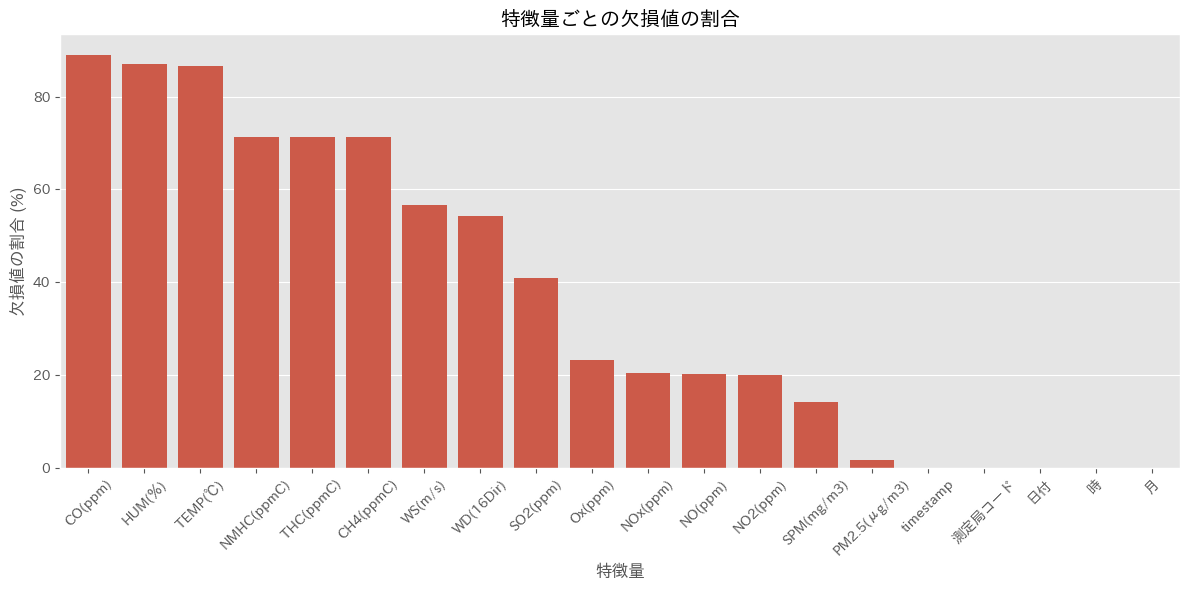


測定局ごとの欠損値の割合(%):
          測定局コード   日付    時  SO2(ppm)  NO(ppm)  NO2(ppm)  NOx(ppm)  CO(ppm)  \
測定局コード                                                                       
1102010      0.0  0.0  0.0      0.62     0.66      0.66      0.66   100.00   
1102020      0.0  0.0  0.0      1.14    41.65     41.65     41.65     0.93   
1107020      0.0  0.0  0.0      0.55     0.55      0.55      0.55   100.00   
1202080      0.0  0.0  0.0    100.00   100.00    100.00    100.00   100.00   
1202100      0.0  0.0  0.0      0.44     0.54      0.54      0.54   100.00   
...          ...  ...  ...       ...      ...       ...       ...      ...   
47206020     0.0  0.0  0.0    100.00     5.42      5.42      5.42   100.00   
47207020     0.0  0.0  0.0      4.28     8.90      8.90      8.90   100.00   
47209080     0.0  0.0  0.0      1.59     2.75      2.75      2.75   100.00   
47211050     0.0  0.0  0.0      3.00     2.96      2.96      2.96   100.00   
47301950     0.0  0.0  0.0     97.49    97.51 

/var/folders/y6/zsgr4wr10g33jjjd_mgpjp640000gp/T/ipykernel_15490/4192561153.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_station = train_df.groupby('測定局コード').apply(


In [10]:
# 特徴量ごとの欠損値の可視化
plt.figure(figsize=(12, 6))
missing_data = (train_df.isnull().sum() / len(train_df) * 100).sort_values(ascending=False)
sns.barplot(x=missing_data.index, y=missing_data.values)
plt.title('特徴量ごとの欠損値の割合')
plt.xlabel('特徴量')
plt.ylabel('欠損値の割合 (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 測定局ごとの欠損値の分析
missing_by_station = train_df.groupby('測定局コード').apply(
    lambda x: x.isnull().mean() * 100
).round(2)

print("\n測定局ごとの欠損値の割合(%):")
print(missing_by_station)

In [11]:
print("訓練データの列名:")
print(train_df.columns.tolist())
print("\nテストデータの列名:")
print(test_df.columns.tolist())

訓練データの列名:
['測定局コード', '日付', '時', 'SO2(ppm)', 'NO(ppm)', 'NO2(ppm)', 'NOx(ppm)', 'CO(ppm)', 'Ox(ppm)', 'NMHC(ppmC)', 'CH4(ppmC)', 'THC(ppmC)', 'SPM(mg/m3)', 'PM2.5(μg/m3)', 'WD(16Dir)', 'WS(m/s)', 'TEMP(℃)', 'HUM(％)', 'timestamp', '月']

テストデータの列名:
['測定局コード', '日付', '時', 'SO2(ppm)', 'NO(ppm)', 'NO2(ppm)', 'NOx(ppm)', 'CO(ppm)', 'Ox(ppm)', 'NMHC(ppmC)', 'CH4(ppmC)', 'THC(ppmC)', 'SPM(mg/m3)', 'WD(16Dir)', 'WS(m/s)', 'TEMP(℃)', 'HUM(％)', 'timestamp', '月']


# 特徴量エンジニアリング

In [12]:
import pandas as pd
import numpy as np
from typing import List, Optional
import holidays
from sklearn.preprocessing import LabelEncoder

class FeatureEngineering:
    """特徴量エンジニアリングを行うクラス"""
    
    def __init__(self):
        self.jp_holidays = holidays.JP()
        self.label_encoders = {}
    
    def create_time_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """時間関連の特徴量を作成"""
        df = df.copy()
        
        # 基本的な時間特徴量
        df['hour'] = df['timestamp'].dt.hour
        df['day'] = df['timestamp'].dt.day
        df['month'] = df['timestamp'].dt.month
        df['dayofweek'] = df['timestamp'].dt.dayofweek
        df['quarter'] = df['timestamp'].dt.quarter
        
        # 時間の周期性を表現する特徴量
        df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
        df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
        df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
        
        # 日時カテゴリ特徴量
        df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
        df['is_holiday'] = df['timestamp'].dt.date.map(
            lambda x: 1 if x in self.jp_holidays else 0
        )
        
        # 時間帯区分
        df['time_period'] = pd.cut(
            df['hour'],
            bins=[-1, 5, 11, 16, 21, 24],
            labels=['dawn', 'morning', 'afternoon', 'evening', 'night']
        )
        
        return df
    
    def create_weather_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """気象関連の特徴量を作成"""
        df = df.copy()
        
        # 風向きのエンコーディング
        if 'WD(16Dir)' in df.columns:
            if 'WD(16Dir)' not in self.label_encoders:
                self.label_encoders['WD(16Dir)'] = LabelEncoder()
                self.label_encoders['WD(16Dir)'].fit(df['WD(16Dir)'].dropna())
            df['WD_encoded'] = self.label_encoders['WD(16Dir)'].transform(
                df['WD(16Dir)'].fillna(df['WD(16Dir)'].mode()[0])
            )
        
        # 気象条件の組み合わせ特徴量
        if all(col in df.columns for col in ['TEMP(℃)', 'HUM(％)']):
            df['temp_hum_interaction'] = df['TEMP(℃)'] * df['HUM(％)']
        
        return df
    
    def create_lag_features(
        self,
        df: pd.DataFrame,
        target_cols: List[str],
        lags: List[int]
    ) -> pd.DataFrame:
        """ラグ特徴量を作成"""
        df = df.copy()
        
        # 実際に存在する列のみを処理
        existing_cols = [col for col in target_cols if col in df.columns]
        
        for col in existing_cols:
            for lag in lags:
                df[f'{col}_lag_{lag}'] = df.groupby('測定局コード')[col].shift(lag)
        
        return df
    
    def create_rolling_features(
        self,
        df: pd.DataFrame,
        target_cols: List[str],
        windows: List[int],
        stats: List[str] = ['mean', 'std', 'max', 'min']
    ) -> pd.DataFrame:
        """移動平均特徴量を作成"""
        df = df.copy()
        
        # 実際に存在する列のみを処理
        existing_cols = [col for col in target_cols if col in df.columns]
        
        for col in existing_cols:
            for window in windows:
                for stat in stats:
                    df[f'{col}_rolling_{window}_{stat}'] = (
                        df.groupby('測定局コード')[col]
                        .rolling(window, min_periods=1)
                        .agg(stat)
                        .reset_index(0, drop=True)
                    )
        
        return df
    
    def create_diff_features(
        self,
        df: pd.DataFrame,
        target_cols: List[str],
        shifts: List[int]
    ) -> pd.DataFrame:
        """差分特徴量を作成"""
        df = df.copy()
        
        # 実際に存在する列のみを処理
        existing_cols = [col for col in target_cols if col in df.columns]
        
        for col in existing_cols:
            for shift in shifts:
                df[f'{col}_diff_{shift}'] = (
                    df.groupby('測定局コード')[col].diff(shift)
                )
        
        return df
    
    def create_all_features(self, df: pd.DataFrame, is_train: bool = True) -> pd.DataFrame:
        """全ての特徴量を作成"""
        df = df.copy()
        
        # タイムスタンプの作成
        df['timestamp'] = pd.to_datetime(
            df['日付'].astype(str) + ' ' + 
            df['時'].astype(str).str.zfill(2) + ':00:00'
        )
        
        # 24時の処理
        mask_24 = df['時'] == 24
        df.loc[mask_24, '時'] = 0
        df.loc[mask_24, 'timestamp'] = df.loc[mask_24, 'timestamp'] + pd.Timedelta(days=1)
        
        # 時間関連特徴量
        df = self.create_time_features(df)
        
        # 気象関連特徴量
        df = self.create_weather_features(df)
        
        # 主要な数値カラム（実際に存在する列のみを使用）
        potential_numeric_cols = [
            'SO2(ppm)', 'NO(ppm)', 'NO2(ppm)', 'NOx(ppm)', 'CO(ppm)',
            'Ox(ppm)', 'NMHC(ppmC)', 'CH4(ppmC)', 'THC(ppmC)',
            'SPM(mg/m3)', 'WS(m/s)', 'TEMP(℃)', 'HUM(％)'
        ]
            
        numeric_cols = [col for col in potential_numeric_cols if col in df.columns]
        
        # ラグ特徴量
        lags = [1, 2, 3, 6, 12, 24]  # 1時間から24時間まで
        df = self.create_lag_features(df, numeric_cols, lags)
        
        # 移動平均特徴量
        windows = [3, 6, 12, 24, 48]  # 3時間から48時間まで
        df = self.create_rolling_features(df, numeric_cols, windows)
        
        # 差分特徴量
        shifts = [1, 2, 3, 6, 12, 24]
        df = self.create_diff_features(df, numeric_cols, shifts)
        
        # 測定局コードのエンコーディング
        if '測定局コード' not in self.label_encoders:
            self.label_encoders['測定局コード'] = LabelEncoder()
            self.label_encoders['測定局コード'].fit(df['測定局コード'])
        df['station_code_encoded'] = self.label_encoders['測定局コード'].transform(df['測定局コード'])
        
        return df

In [13]:
# 特徴量エンジニアリングの実行例
fe = FeatureEngineering()
train_features = fe.create_all_features(train_df)
test_features = fe.create_all_features(test_df)

# 特徴量の確認
print("生成された特徴量の数:", len(train_features.columns))
print("\n新しい特徴量のリスト:")
new_features = [col for col in train_features.columns if col not in train_df.columns]
print("\n".join(new_features))

/var/folders/y6/zsgr4wr10g33jjjd_mgpjp640000gp/T/ipykernel_15490/3609449470.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_{window}_{stat}'] = (
/var/folders/y6/zsgr4wr10g33jjjd_mgpjp640000gp/T/ipykernel_15490/3609449470.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_rolling_{window}_{stat}'] = (
/var/folders/y6/zsgr4wr10g33jjjd_mgpjp640000gp/T/ipykernel_15490/3609449470.py:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

生成された特徴量の数: 451

新しい特徴量のリスト:
hour
day
month
dayofweek
quarter
hour_sin
hour_cos
month_sin
month_cos
is_weekend
is_holiday
time_period
WD_encoded
temp_hum_interaction
SO2(ppm)_lag_1
SO2(ppm)_lag_2
SO2(ppm)_lag_3
SO2(ppm)_lag_6
SO2(ppm)_lag_12
SO2(ppm)_lag_24
NO(ppm)_lag_1
NO(ppm)_lag_2
NO(ppm)_lag_3
NO(ppm)_lag_6
NO(ppm)_lag_12
NO(ppm)_lag_24
NO2(ppm)_lag_1
NO2(ppm)_lag_2
NO2(ppm)_lag_3
NO2(ppm)_lag_6
NO2(ppm)_lag_12
NO2(ppm)_lag_24
NOx(ppm)_lag_1
NOx(ppm)_lag_2
NOx(ppm)_lag_3
NOx(ppm)_lag_6
NOx(ppm)_lag_12
NOx(ppm)_lag_24
CO(ppm)_lag_1
CO(ppm)_lag_2
CO(ppm)_lag_3
CO(ppm)_lag_6
CO(ppm)_lag_12
CO(ppm)_lag_24
Ox(ppm)_lag_1
Ox(ppm)_lag_2
Ox(ppm)_lag_3
Ox(ppm)_lag_6
Ox(ppm)_lag_12
Ox(ppm)_lag_24
NMHC(ppmC)_lag_1
NMHC(ppmC)_lag_2
NMHC(ppmC)_lag_3
NMHC(ppmC)_lag_6
NMHC(ppmC)_lag_12
NMHC(ppmC)_lag_24
CH4(ppmC)_lag_1
CH4(ppmC)_lag_2
CH4(ppmC)_lag_3
CH4(ppmC)_lag_6
CH4(ppmC)_lag_12
CH4(ppmC)_lag_24
THC(ppmC)_lag_1
THC(ppmC)_lag_2
THC(ppmC)_lag_3
THC(ppmC)_lag_6
THC(ppmC)_lag_12
THC(ppmC)_lag_24


In [14]:
train_features

,測定局コード,日付,時,SO2(ppm),NO(ppm),NO2(ppm),NOx(ppm),CO(ppm),Ox(ppm),NMHC(ppmC),...,TEMP(℃)_diff_6,TEMP(℃)_diff_12,TEMP(℃)_diff_24,HUM(％)_diff_1,HUM(％)_diff_2,HUM(％)_diff_3,HUM(％)_diff_6,HUM(％)_diff_12,HUM(％)_diff_24,station_code_encoded
0,1102010,2024/06/01,1,0.0,0.000,0.002,0.002,NaN,0.027,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1102010,2024/06/01,2,0.0,0.000,0.002,0.002,NaN,0.027,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1102010,2024/06/01,3,0.0,0.001,0.005,0.006,NaN,0.019,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1102010,2024/06/01,4,0.0,0.000,0.004,0.004,NaN,0.016,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1102010,2024/06/01,5,0.0,0.001,0.006,0.007,NaN,0.013,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093075,46225010,2025/02/28,20,NaN,NaN,NaN,NaN,NaN,0.021,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,257
2093076,46225010,2025/02/28,21,NaN,NaN,NaN,NaN,NaN,0.015,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,257
2093077,46225010,2025/02/28,22,NaN,NaN,NaN,NaN,NaN,0.012,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,257
2093078,46225010,2025/02/28,23,NaN,NaN,NaN,NaN,NaN,0.010,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,257


In [15]:
test_features

,測定局コード,日付,時,SO2(ppm),NO(ppm),NO2(ppm),NOx(ppm),CO(ppm),Ox(ppm),NMHC(ppmC),...,TEMP(℃)_diff_6,TEMP(℃)_diff_12,TEMP(℃)_diff_24,HUM(％)_diff_1,HUM(％)_diff_2,HUM(％)_diff_3,HUM(％)_diff_6,HUM(％)_diff_12,HUM(％)_diff_24,station_code_encoded
0,1107020,2025/04/01,1,0.000,0.0,0.004,0.004,NaN,0.050,0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,1107020,2025/04/01,2,NaN,NaN,NaN,NaN,NaN,0.048,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,1107020,2025/04/01,3,0.001,0.0,0.005,0.005,NaN,0.045,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,1107020,2025/04/01,4,0.001,0.0,0.008,0.008,NaN,0.043,0.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,1107020,2025/04/01,5,0.001,0.0,0.010,0.010,NaN,0.040,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243490,47301950,2025/02/28,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263
243491,47301950,2025/02/28,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263
243492,47301950,2025/02/28,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263
243493,47301950,2025/02/28,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263


In [16]:
set(train_features.columns) - set(test_features.columns)


{'PM2.5(μg/m3)'}

In [17]:
train_features.to_pickle('../data/model_input/train_features.pkl')
test_features.to_pickle('../data/model_input/test_features.pkl')